# Testing different functions and implementations
___
1. Euclidean distance implementation
2. Manhattan distance implementation
3. Testing KNN classification with leave-one-out cross-validation using SKLEARN

In [2]:
# imports
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [9]:
# dataset
dataset = arff.loadarff('ionosphere.arff')
dataset = pd.DataFrame(dataset[0])
dataset = dataset.to_numpy()
X = dataset[:, :-1].astype(np.float64) # cast datatype from 'float' to 'np.float64' (seems to be faster)
y = dataset[:, -1]
labels, y = np.unique(y, return_inverse=True) # map labels to ints (labels[0] -> 0, labels[1] -> 1)
print(X.shape)
print(y.shape)
del dataset

(351, 34)
(351,)


## Testing Euclidean distance implementation
___
Conclusion: euclidean3() seems to be best. BUT if we calculate the distances with matrix operations it will be much faster.

In [20]:
# Euclidean functions
def euclidean1(x1, x2):
    diff = x2 - x1
    return np.sqrt(np.sum((diff)**2))

def euclidean2(x1, x2):
    diff = x2 - x1
    return np.sqrt(np.sum(np.square(diff)))

def euclidean3(x1, x2):
    diff = x2 - x1
    return np.sqrt(np.dot(diff, diff))

def euclidean4(x1, x2):
    diff = x2 - x1
    return np.sqrt(np.inner(diff, diff))

def euclidean5(x1, x2):
    diff = x2 - x1
    return np.sqrt(np.einsum('i,i->', diff, diff))

# Output of functions
n = X.shape[0] # number of examples
x1 = X[np.random.randint(0, n)] # random example
x2 = X[np.random.randint(0, n)] # random example

In [5]:
# Testing the runtime for different implementations of the Euclidean distance function
print('np.linalg.norm(): ', end='')
%timeit diff = x2 - x1; np.linalg.norm(diff)
print('euclidean1: ', end='')
%timeit euclidean1(x2, x1)
print('euclidean2: ', end='')
%timeit euclidean2(x2, x1)
print('euclidean3: ', end='')
%timeit euclidean3(x2, x1)
print('euclidean4: ', end='')
%timeit euclidean4(x2, x1)
print('euclidean5: ', end='')
%timeit euclidean5(x2, x1)

np.linalg.norm(): 5.92 µs ± 326 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
euclidean1: 7.8 µs ± 407 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
euclidean2: 7.24 µs ± 444 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
euclidean3: 3.96 µs ± 263 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
euclidean4: 4.21 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
euclidean5: 5.39 µs ± 246 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Testing Manhattan distance implementation
___
Conclusion: Not many other ways/functions to use to implement manhattan distance.

In [6]:
def manhattan(x1, x2):
    return np.sum(np.abs(x2 - x1))

In [7]:
# Test runtime of manhattan distance implementation
%timeit diff = x2 - x1; np.linalg.norm(diff, ord=1)
%timeit manhattan(x1, x2)

6.71 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.14 µs ± 392 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Sklearn KNN Classifier
___
I think this is how they want us to calculate accuracy. Train on all except 1 example, then predict on that single test example. Repeat for all possible splits. There should be m splits where m is the number of examples in the dataset.

In [164]:
# No feature scaling
def KNNclassifierWithLOO(X, y, k):
    # Leave one out cross-validation
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    # KNN classifier
    correct_count = 0;
    total_count = y.shape[0];
    classifier = KNeighborsClassifier(n_neighbors = k)

    # Train on each split and predict on the single test example
    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        if y_pred == y_test:
            correct_count += 1

    #print(correct_count, 'out of', total_count, 'correctly classified')
    #print('accuracy:', correct_count / total_count)
    return correct_count / total_count

In [165]:
accuracy = KNNclassifierWithLOO(X, y, 3) # 3 nearest neighbours
print('accuracy:', accuracy)

accuracy: 0.8490028490028491


In [166]:
%timeit KNNclassifierWithLOO(X, y, 3)

371 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [167]:
# With standard scaler
def KNNclassifierWithLOOandStandardScaler(X, y, k):
    # Leave one out cross-validation
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    # KNN classifier
    correct_count = 0;
    total_count = y.shape[0];
    classifier = KNeighborsClassifier(n_neighbors = k)
    scaler = StandardScaler()

    # Train on each split and predict on the single test example
    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        if y_pred == y_test:
            correct_count += 1

    #print(correct_count, 'out of', total_count, 'correctly classified')
    #print('accuracy:', correct_count / total_count)
    return correct_count / total_count

In [168]:
accuracy = KNNclassifierWithLOOandStandardScaler(X, y, 3)
print('accuracy:', accuracy)

accuracy: 0.8461538461538461


In [169]:
# With min max scaler
def KNNclassifierWithLOOandMinMaxScaler(X, y, k):
    # Leave one out cross-validation
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    # KNN classifier
    correct_count = 0;
    total_count = y.shape[0];
    classifier = KNeighborsClassifier(n_neighbors = k)
    scaler = MinMaxScaler()

    # Train on each split and predict on the single test example
    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        if y_pred == y_test:
            correct_count += 1

    #print(correct_count, 'out of', total_count, 'correctly classified')
    #print('accuracy:', correct_count / total_count)
    return correct_count / total_count

In [170]:
accuracy = KNNclassifierWithLOOandMinMaxScaler(X, y, 3)
print('accuracy:', accuracy)

accuracy: 0.8603988603988604


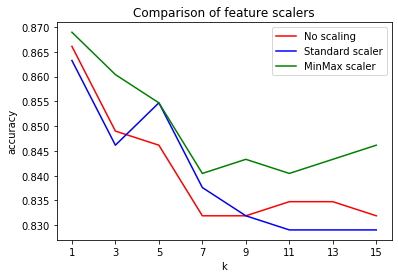

In [171]:
n_neighbours = [1, 3, 5, 7, 9, 11, 13, 15]
acc1 = []
acc2 = []
acc3 = []

for k in n_neighbours:
    acc1.append(KNNclassifierWithLOO(X, y, k))
    acc2.append(KNNclassifierWithLOOandStandardScaler(X, y, k))
    acc3.append(KNNclassifierWithLOOandMinMaxScaler(X, y, k))

plt.plot(n_neighbours, acc1, 'r-', label='No scaling')
plt.plot(n_neighbours, acc2, 'b-', label='Standard scaler')
plt.plot(n_neighbours, acc3, 'g-', label='MinMax scaler')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xticks(n_neighbours)
plt.title('Comparison of feature scalers')
plt.legend()
plt.show()

# Simple KNN Classifier (without LOO)
___
Reusing code from our KNN_Class with some changes.

ANALYSIS: Time complexity, fitting time, prediction time.

In [257]:
import numpy as np
from heapq import heappush, heappop

def euclidean(x1, x2):
    diff = x2 - x1
    return np.sqrt(np.dot(diff, diff))

In [300]:
# No fitting. All time spent on prediction.
class SimpleKNNClassifier:
    def __init__(self, n_neighbours, dist_metric='euclidean'):
        assert(dist_metric == 'euclidean' or dist_metric=='manhattan')
        self.n_neighbours = n_neighbours
        if dist_metric == 'euclidean':
            self.dist_metric = euclidean
        else:
            self.dist_metric = manhattan
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict_single1(self, x): # Does not take advantage of matrix operations
        n = self.X_train.shape[0] # number of training examples
        pairs = [] # list of (distance, label) pairs
        for i in range(n):
            pairs.append((self.dist_metric(self.X_train[i], x), self.y_train[i]))
        pairs.sort(key = lambda pair: pair[0])
        nearest = [pair[1] for pair in pairs[:self.n_neighbours]] # get labels of nearest neighbours
        return max(set(nearest), key=nearest.count)
 
    def predict_single2(self, x): # Does not take advantage of matrix operations but uses heap
        n = self.X_train.shape[0] # number of training examples
        pairs = [] # list of (distance, label) pairs
        for i in range(n):
            heappush(pairs, (self.dist_metric(self.X_train[i], x), self.y_train[i]))
        nearest = []
        for i in range(self.n_neighbours):
            nearest.append(heappop(pairs)[1])
        return max(set(nearest), key=nearest.count)

    def predict_single3(self, x): # Takes advantage of matrix operations
        diff = self.X_train - x
        distances = np.sqrt(np.sum(np.square(diff, diff), axis=1))
        pairs = np.stack([distances, self.y_train], axis=1) # distance and label
        pairs = pairs[pairs[:, 0].argsort()] # sort by distance
        nearest = pairs[:self.n_neighbours, 1].astype('int64') # label of nearest neighbours
        return np.bincount(nearest).argmax()
    
    def predict_single4(self, x): # Takes advantage of matrix operations and uses heap
        diff = self.X_train - x
        distances = np.sqrt(np.sum(np.square(diff, diff), axis=1))
        pairs = np.stack([distances, self.y_train], axis=1) # distance and label
        pairs = pairs.tolist() # convert to list for heap ops
        nearest = []
        ordered = []
        for pair in pairs: # have to push all pairs to a heap
            heappush(ordered, pair)
        for i in range(self.n_neighbours): # and then pop them
            nearest.append(int(heappop(ordered)[1]))
        return max(set(nearest), key=nearest.count)
    

    def predict1(self, X_test): # NO matrix ops
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single1(x))
        return np.asarray(y_pred)
    
    def predict2(self, X_test): # NO matrix ops uses heap
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single2(x))
        return np.asarray(y_pred)
    
    def predict3(self, X_test): # Matrix ops
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single3(x))
        return np.asarray(y_pred)           
        
    def predict4(self, X_test): # Matrix ops
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single4(x))
        return np.asarray(y_pred)

In [301]:
classifier = SimpleKNNClassifier(n_neighbours=3)
classifier.fit(X, y)
print(classifier.predict4(X_test))
print(classifier.predict3(X_test))
print(classifier.predict2(X_test))
print(classifier.predict1(X_test))

[1 0 1 0 0]
[1 0 1 0 0]
[1 0 1 0 0]
[1 0 1 0 0]


In [293]:
# Testing our naive classifier
X_test = X[np.random.randint(X.shape[0], size=5), :]

classifier = SimpleKNNClassifier(n_neighbours=3)
classifier.fit(X, y)
classifier.predict3(X_test)

%timeit classifier.predict1(X_test)
%timeit classifier.predict2(X_test)
%timeit classifier.predict3(X_test)
%timeit classifier.predict4(X_test)

7.89 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.47 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
399 µs ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
755 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [181]:
# Testing sklearn classifier
classifiersk = KNeighborsClassifier(n_neighbors = 3)
classifiersk.fit(X, y)
classifiersk.predict(X_test)

%timeit classifiersk.predict(X_test)

695 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In the first approach we do not take advantage of matrix operations and we do not use a heap.
In the second approach we use a heap.
In the third approach we use matrix operations.
In the fourth approach we use matrix operations and a heap, however, to use the heap we had to scan through the matrix and push each pair into a heap and then pop them to find the nearest.

On this dataset approach 3 is best.

# Space paritioning Classifier
___
When it comes to nearest neighbour we have two classes of methods: linear search and space partitioning. So far we have done linear search.

In [ ]:
# Include performance comparison of naive vs. better vs. sklearn

# Test classifier with different settings
___
Feature scaling: MinMax scaler, standard scaler, etc.
Number of neighbours: 1, 3, 5, etc.
Different datasets: Try other datasets.


Plot accuracy vs. number of neighbours like above plot.

*Note: Could implement scalers ourselves.

# Visualize classifier
___
Use PCA to reduce features to 2 so it can be plotted. Plot decision boundary.

# Prediction
___
repeat some of the stuff abov but for prediction.

In [334]:
# dataset
data_set = arff.loadarff('autos.arff')
data = pd.DataFrame(data_set[0])
    
# Remove any categorical labels (Note: temporary as we can encode these categorical labels later)
data.drop(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
            'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 
            'fuel-system'], axis=1, inplace=True)

# Remove missing values
filtered = data.dropna()
print(filtered.shape)

# Separate labels & x-data
y = filtered['price'].to_numpy()
X = filtered.drop('price', axis=1).to_numpy().astype(np.float64)

(160, 16)


In [335]:
print(type(X[0,1]))

<class 'numpy.float64'>


In [448]:
# No fitting. All time spent on prediction.
class SimpleKNNRegressor:
    def __init__(self, n_neighbours, dist_metric='euclidean'):
        assert(dist_metric == 'euclidean' or dist_metric=='manhattan')
        self.n_neighbours = n_neighbours
        if dist_metric == 'euclidean':
            self.dist_metric = euclidean
        else:
            self.dist_metric = manhattan
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict_single1(self, x): # Does not take advantage of matrix operations
        n = self.X_train.shape[0] # number of training examples
        pairs = [] # list of (distance, label) pairs
        for i in range(n):
            pairs.append((self.dist_metric(self.X_train[i], x), self.y_train[i]))
        pairs.sort(key = lambda pair: pair[0])
        nearest = [pair[1] for pair in pairs[:self.n_neighbours]] # get labels of nearest neighbours
        return np.mean(nearest)
 
    def predict_single2(self, x): # Does not take advantage of matrix operations but uses heap
        n = self.X_train.shape[0] # number of training examples
        pairs = [] # list of (distance, label) pairs
        for i in range(n):
            heappush(pairs, (self.dist_metric(self.X_train[i], x), self.y_train[i]))
        nearest = []
        for i in range(self.n_neighbours):
            nearest.append(heappop(pairs)[1])
        return np.mean(nearest)

    def predict_single3(self, x): # Takes advantage of matrix operations
        diff = self.X_train - x
        distances = np.sqrt(np.sum(np.square(diff, diff), axis=1))
        pairs = np.stack([distances, self.y_train], axis=1) # distance and label
        pairs = pairs[pairs[:, 0].argsort(kind='stable')] # sort by distance
        nearest = pairs[:self.n_neighbours, 1].astype(np.int64) # label of nearest neighbours
        return np.mean(nearest)
    
    def predict_single4(self, x): # Takes advantage of matrix operations and uses heap
        diff = self.X_train - x
        distances = np.sqrt(np.sum(np.square(diff, diff), axis=1))
        pairs = np.stack([distances, self.y_train], axis=1) # distance and label
        pairs = pairs.tolist() # convert to list for heap ops
        nearest = []
        ordered = []
        for pair in pairs: # have to push all pairs to a heap
            heappush(ordered, pair)
        for i in range(self.n_neighbours): # and then pop them
            nearest.append(int(heappop(ordered)[1]))
        return np.mean(nearest)
    

    def predict1(self, X_test): # NO matrix ops
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single1(x))
        return np.asarray(y_pred)
    
    def predict2(self, X_test): # NO matrix ops uses heap
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single2(x))
        return np.asarray(y_pred)
    
    def predict3(self, X_test): # Matrix ops
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single3(x))
        return np.asarray(y_pred)           
        
    def predict4(self, X_test): # Matrix ops
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict_single4(x))
        return np.asarray(y_pred)

In [449]:
X_test = X[np.random.randint(X.shape[0], size=5), :]

classifier = SimpleKNNRegressor(n_neighbours=3)
classifier.fit(X, y)
print(classifier.predict4(X_test))
print(classifier.predict3(X_test))
print(classifier.predict2(X_test))
print(classifier.predict1(X_test))

[18432.33333333  9359.          8611.66666667 15256.66666667
 11430.        ]
[18432.33333333  9359.          8611.66666667 15256.66666667
 11430.        ]
[18432.33333333  9359.          8611.66666667 15256.66666667
 11430.        ]
[18432.33333333  9359.          8611.66666667 15256.66666667
 11430.        ]


In [450]:
classifiersk = KNeighborsRegressor(n_neighbors = 3)
classifiersk.fit(X, y)
classifiersk.predict(X_test)

array([18432.33333333,  9359.        ,  8611.66666667, 15256.66666667,
       11430.        ])

In [451]:
# Testing our naive regressor
X_test = X[np.random.randint(X.shape[0], size=5), :]

classifier = SimpleKNNRegressor(n_neighbours=3)
classifier.fit(X, y)
classifier.predict3(X_test)

%timeit classifier.predict1(X_test)
%timeit classifier.predict2(X_test)
%timeit classifier.predict3(X_test)
%timeit classifier.predict4(X_test)

4.03 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.34 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
307 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
502 µs ± 9.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [452]:
# Testing sklearn classifier
classifiersk = KNeighborsRegressor(n_neighbors = 3)
classifiersk.fit(X, y)
classifiersk.predict(X_test)

%timeit classifiersk.predict(X_test)

384 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Clearly matrix operations make things much faster.

Test error as k increases

Cross validation for KNN classification
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.15384615384615385
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16524216524216523
Predicted error of KNN Classification: 0.16524216524216523
Predicted error of KNN Classification: 0.16809116809116809
Cross validation for KNN classification
Predicted error of KNN Classification: 0.09116809116809117
Predicted error of KNN Classification: 0.1111111111111111
Predicted error of KNN Classification: 0.11396011396011396
Predicted error of KNN Classification: 0.1168091168091168
Predicted error of KNN Classification: 0.11965811965811966
Predicted error of KNN Classification: 0.1282051282051282
Predicted error of KNN Classification: 0.1396011396011396
Predicted error of KNN Classification: 0.1

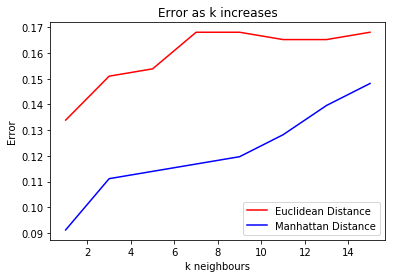

In [5]:
import test
from distance import Euclidean, Manhattan
eu_err = test.standard_classification_test(distance = Euclidean())
ma_err = test.standard_classification_test(distance = Manhattan())
n_neighbours = [1, 3, 5, 7, 9, 11, 13, 15]
plt.plot(n_neighbours, eu_err, 'r-', label = "Euclidean Distance")
plt.plot(n_neighbours, ma_err, 'b-', label = "Manhattan Distance")
plt.xlabel('k neighbours')
plt.ylabel('Error')
plt.title('Error as k increases')
#plt.xticks(n_neighbours)
plt.legend()
plt.show()

In [ ]:
# With min max scaler
def SameTestAsAbove(X, y, k, p):
    # Leave one out cross-validation
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    # KNN classifier
    wrong_count = 0;
    total_count = y.shape[0];
    classifier = KNeighborsClassifier(n_neighbors = k, p=p)

    # Train on each split and predict on the single test example
    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        if y_pred != y_test:
            wrong_count += 1

    return wrong_count / total_count

In [7]:
euclid = []
manhat = []
n_neighbours = [1, 3, 5, 7, 9, 11, 13, 15]
for k in n_neighbours:
    euclid.append(SameTestAsAbove(X, y, k, 2)) # 2 = 2 norm (euclidean)
    manhat.append(SameTestAsAbove(X, y, k, 1)) # 1 = 1 norm (manhattan)


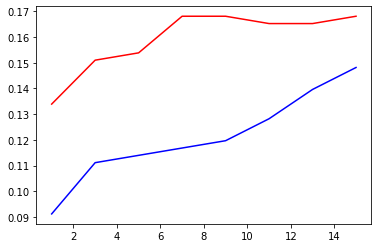

In [8]:
plt.plot(n_neighbours, euclid, 'r-', label='euclid')
plt.plot(n_neighbours, manhat, 'b-', label='manhat')
plt.show()

In [2]:
from KNN_Class import *

data_set = arff.loadarff('ionosphere.arff')
data = pd.DataFrame(data_set[0]).to_numpy()
x_data = data[:, :-1]
labels = data[:, -1]

err1 = []
err2 = []
err3 = []
err4 = []
err5 = []
n_neighbours = [1,2, 3,4, 5,6, 7,8, 9, 10,11,12, 13,14, 15]
for i in n_neighbours:
    nverr = cross_validation(x_data, labels, KNN_Class(), i)
    err1.append(nverr)
    bterr = cross_validation(x_data, labels, WKNN_Class(weight=1), i)
    err2.append(bterr)
    err3.append(cross_validation(x_data, labels, WKNN_Class(weight=2), i))
    err4.append(cross_validation(x_data, labels, WKNN_Class(weight=3), i))
    err5.append(cross_validation(x_data, labels, WKNN_Class(weight=4), i))

Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.14814814814814814
Predicted error of KNN Classification: 0.150997150997151
Predicted error of 

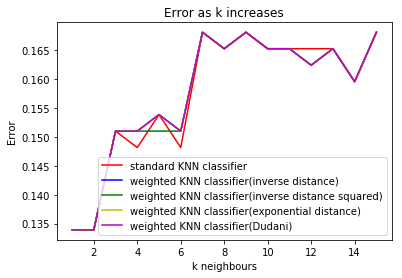

In [4]:

plt.plot(n_neighbours, err1, 'r-', label = "standard KNN classifier")
plt.plot(n_neighbours, err2, 'b-', label = "weighted KNN classifier(inverse distance)")
plt.plot(n_neighbours, err3, 'g-', label = "weighted KNN classifier(inverse distance squared)")
plt.plot(n_neighbours, err4, 'y-', label = "weighted KNN classifier(exponential distance)")
plt.plot(n_neighbours, err5, 'm-', label = "weighted KNN classifier(Dudani)")
plt.xlabel('k neighbours')
plt.ylabel('Error')
plt.title('Error as k increases')
#plt.xticks(n_neighbours)
plt.legend()
plt.show()

In [1]:
from KNN_Class import *

data_set = arff.loadarff('ionosphere.arff')
data = pd.DataFrame(data_set[0]).to_numpy()
x_data = data[:, :-1]
labels = data[:, -1]

err1 = []
err2 = []
n_neighbours = [1, 3, 5, 7, 9, 11, 13, 15]
for i in n_neighbours:
    nverr = cross_validation(x_data, labels, KNN_Class(), i)
    err1.append(nverr)
    bterr = cross_validation(x_data, labels, KNN_Class(), i, method="BallTree")
    err2.append(bterr)

Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.1339031339031339
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.150997150997151
Predicted error of KNN Classification: 0.15384615384615385
Predicted error of KNN Classification: 0.15384615384615385
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16524216524216523
Predicted error of KNN Classification: 0.16524216524216523
Predicted error of KNN Classification: 0.16524216524216523
Predicted error of KNN Classification: 0.16524216524216523
Predicted error of KNN Classification: 0.16809116809116809
Predicted error of KNN Classification: 0.16809116809116809


[0.1339031339031339, 0.150997150997151, 0.15384615384615385, 0.16809116809116809, 0.16809116809116809, 0.16524216524216523, 0.16524216524216523, 0.16809116809116809]
[0.15669515669515668, 0.15954415954415954, 0.16524216524216523, 0.18518518518518517, 0.19658119658119658, 0.22792022792022792, 0.2535612535612536, 0.28774928774928776]


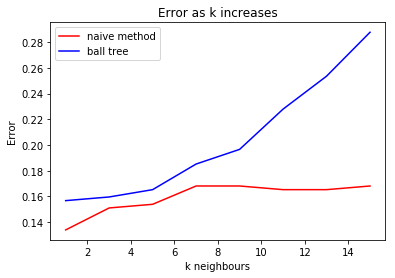

In [3]:
print(err1)
print(err2)
plt.plot(n_neighbours, err1, 'r-', label = "naive method")
plt.plot(n_neighbours, err2, 'b-', label = "ball tree")
plt.xlabel('k neighbours')
plt.ylabel('Error')
plt.title('Error as k increases')
#plt.xticks(n_neighbours)
plt.legend()
plt.show()

In [22]:
from target import *
p = 0.5
num_samples = 351
num_f = 34
np.random.seed(201923)
n_neighbours = [1, 3, 5, 7, 9, 11, 13, 15]
for k in n_neighbours:
    k_err = []
    for i in range(0, 5):

        mean0 = generate_mean(num_f)
        cov0 = generate_covariance_matrix(num_f)
        target0 = TargetFunction(mean0, cov0, num_f, 0)

        mean1 = generate_mean(num_f)
        cov1 = generate_covariance_matrix(num_f)
        target1 = TargetFunction(mean1, cov1, num_f, 1)

        #print('------------------------------')
        #print(f'Generating data based on target function {p} probability between the two classes...')

        class_0, class_1 = generate_dataset(p, num_samples, target0, target1)
        #print(class_0.shape, class_1.shape)
        #print(f'First 2 data points of class 0: \n{class_0[:2]}')
        #print(f'First 2 data points of class 1: \n{class_1[:2]}')

        #print('------------------------------')
        #print('Creating data set')
        x_data, labels = make_useable_dataset(class_0, 0, class_1, 1)
        #print(f'First 2 data points of x_data:\n{x_data[:2]}')
        #print(f'First 2 data points labels:\n{labels[:2]}')

        #err = calc_bayes_error(x_data, labels, target0, p, target1, (1-p))
        #print(f'Bayes error rate on this dataset: {err*100:.20f}%')
        # err = calc_bayes_error(x_data, labels, target0, target1)
        # print(f'Estimated Bayes error rate on this dataset: {err}%')

        #print('------------------------------')
        #print('Using dataset with KNN...')
        k_err.append(cross_validation(x_data, labels, KNN_Class(), k))
    print("error with k = " + str(k) + " is " + str(np.mean(k_err)))

Predicted error of KNN Classification: 0.017094017094017096
Predicted error of KNN Classification: 0.005698005698005698
Predicted error of KNN Classification: 0.0
Predicted error of KNN Classification: 0.011396011396011397
Predicted error of KNN Classification: 0.002849002849002849
error with k = 1 is 0.0074074074074074086
Predicted error of KNN Classification: 0.005698005698005698
Predicted error of KNN Classification: 0.002849002849002849
Predicted error of KNN Classification: 0.0
Predicted error of KNN Classification: 0.002849002849002849
Predicted error of KNN Classification: 0.008547008547008548
error with k = 3 is 0.003988603988603989
Predicted error of KNN Classification: 0.0
Predicted error of KNN Classification: 0.002849002849002849
Predicted error of KNN Classification: 0.002849002849002849
Predicted error of KNN Classification: 0.0
Predicted error of KNN Classification: 0.0
error with k = 5 is 0.0011396011396011397
Predicted error of KNN Classification: 0.0
Predicted error o

In [1]:
from KNN_Numeric import *
# Load data from autos.aff
data_set = arff.loadarff('autos.arff')
data = pd.DataFrame(data_set[0])    

# Make new numeric labels for each of these categorical labels 
data = convert_to_numeric(data, ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
                'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 
                'fuel-system'])
    
# Remove the old categorical labels 
data.drop(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
                'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 
                'fuel-system', 'normalized-losses'], axis=1, inplace=True)

# Remove missing values
filtered = data.dropna()
#print(data)
print(filtered.shape)

# Separate labels & x-data
labels = filtered['price'].to_numpy()
x_data = filtered.drop('price', axis=1)

# TEMPORARY TEST FOR KNN NUMERIC
# Test_KNN_Numeric(x_data, labels)

# Cross Validation for KNN
err1 = []
err2 = []
err3 = []
err4 = []
err5 = []
n_neighbours = [1,2, 3,4, 5,6, 7,8, 9, 10,11,12, 13,14, 15]
for i in n_neighbours:
    nverr = cross_validation(x_data, labels, KNN_Numeric(), i)
    err1.append(nverr)
    bterr = cross_validation(x_data, labels, WKNN_Numeric(weight=1), i)
    err2.append(bterr)
    err3.append(cross_validation(x_data, labels, WKNN_Numeric(weight=2), i))
    err4.append(cross_validation(x_data, labels, WKNN_Numeric(weight=3), i))
    err5.append(cross_validation(x_data, labels, WKNN_Numeric(weight=4), i))

(195, 25)
Mean of predicted error of KNN: 2018.1538461538462
Mean of predicted error of KNN: 2018.1538461538462
Mean of predicted error of KNN: 2018.1538461538462
Mean of predicted error of KNN: 2018.1538461538462
Mean of predicted error of KNN: 2018.1538461538462
Mean of predicted error of KNN: 1792.0897435897436
Mean of predicted error of KNN: 1809.001988614891
Mean of predicted error of KNN: 1820.1893439916666
Mean of predicted error of KNN: 1775.5937219280463
Mean of predicted error of KNN: 2026.1897436050158
Mean of predicted error of KNN: 1797.0205128205127
Mean of predicted error of KNN: 1781.8305343145935
Mean of predicted error of KNN: 1782.8200354738415
Mean of predicted error of KNN: 1741.143849430893
Mean of predicted error of KNN: 1792.3281271260723
Mean of predicted error of KNN: 1944.7102564102563
Mean of predicted error of KNN: 1814.293245055744
Mean of predicted error of KNN: 1796.2406057887263
Mean of predicted error of KNN: 1819.1978300857963
Mean of predicted error 

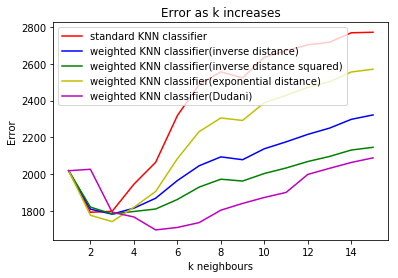

In [3]:

plt.plot(n_neighbours, err1, 'r-', label = "standard KNN classifier")
plt.plot(n_neighbours, err2, 'b-', label = "weighted KNN classifier(inverse distance)")
plt.plot(n_neighbours, err3, 'g-', label = "weighted KNN classifier(inverse distance squared)")
plt.plot(n_neighbours, err4, 'y-', label = "weighted KNN classifier(exponential distance)")
plt.plot(n_neighbours, err5, 'm-', label = "weighted KNN classifier(Dudani)")
plt.xlabel('k neighbours')
plt.ylabel('Error')
plt.title('Error as k increases')
#plt.xticks(n_neighbours)
plt.legend()
plt.show()

In [7]:
from KNN_Numeric import *
# Load data from autos.aff
data_set = arff.loadarff('autos.arff')
data = pd.DataFrame(data_set[0])    

# Make new numeric labels for each of these categorical labels 
data = convert_to_numeric(data, ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
                'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 
                'fuel-system'])
    
# Remove the old categorical labels 
data.drop(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
                'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 
                'fuel-system', 'normalized-losses'], axis=1, inplace=True)

# Remove missing values
filtered = data.dropna()
#print(data)
print(filtered.shape)

# Separate labels & x-data
labels = filtered['price'].to_numpy()
x_data = filtered.drop('price', axis=1)
n_neighbours = [1, 3, 5, 7, 9, 11, 13, 15]

# TEMPORARY TEST FOR KNN NUMERIC
# Test_KNN_Numeric(x_data, labels)

# Cross Validation for KNN
print("Cross Validation for normal KNN")
eu_err = []
mh_err = []
for i in n_neighbours:
    eu_err.append(cross_validation(x_data, labels, KNN_Numeric(), i))
    
# Cross Validiation for KNN Weighted
print("Cross Validation for weighted KNN")
for i in n_neighbours:
    mh_err.append(cross_validation(x_data, labels, KNN_Numeric(), i, distance=Manhattan()))
    
print(eu_err)
print(mh_err)

(195, 25)
Cross Validation for normal KNN
Std deviation of predicted error of KNN: 3122.7401694743435
Std deviation of predicted error of KNN: 2726.753733400271
Std deviation of predicted error of KNN: 3213.3849956081726
Std deviation of predicted error of KNN: 3929.233906389519
Std deviation of predicted error of KNN: 4104.333910986562
Std deviation of predicted error of KNN: 4429.375193332076
Std deviation of predicted error of KNN: 4584.536131916225
Std deviation of predicted error of KNN: 4679.280754099769
Cross Validation for weighted KNN
Std deviation of predicted error of KNN: 5180.216072155131
Std deviation of predicted error of KNN: 4820.043755089667
Std deviation of predicted error of KNN: 5872.6248211819775
Std deviation of predicted error of KNN: 5903.093030863458
Std deviation of predicted error of KNN: 5918.088510227018
Std deviation of predicted error of KNN: 5922.197290174808
Std deviation of predicted error of KNN: 6093.544715772409
Std deviation of predicted error of 

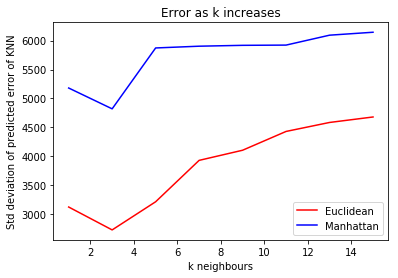

In [8]:
plt.plot(n_neighbours, eu_err, 'r-', label = "Euclidean")
plt.plot(n_neighbours, mh_err, 'b-', label = "Manhattan")
plt.xlabel('k neighbours')
plt.ylabel('Std deviation of predicted error of KNN')
plt.title('Error as k increases')
#plt.xticks(n_neighbours)
plt.legend()
plt.show()